Importing useful librairies and setting plot parameters

In [13]:
import sys
import pandas as pd
import numpy as np
import ta
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.utils import shuffle
import pandas as pd
import glob
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
import warnings
warnings.filterwarnings("ignore")
sys.path.append('./functions')
from useful_functions import *
from indicators import *

plt.rcParams['figure.figsize'] = (30, 15)
plt.rcParams['figure.facecolor'] = "white"
plt.rcParams['axes.facecolor'] = "white"
plt.rcParams['axes.edgecolor'] = "black"


Loading csv files w/ cryptocurrency data and merge them together

Loading indicators, cleaning dataframe

In [2]:
path = r'data/1d'
all_files = glob.glob(path + '/*.csv')
li = []
for filename in all_files:
    data = pd.read_csv(filename, index_col=None, header=0)
    li.append(data)

frame = pd.concat(li, axis=0, ignore_index=True)

data = frame.set_index(frame['date'])
data.index = pd.to_datetime(data.index, unit='ms')
del data['date']

# POSITIVE BREAKOUT
get_indicators(data)

del data['open']
del data['high']
del data['low']

data['pct_change'] = data.close.pct_change().shift(-1)
data['previous_pct_change'] = data.close.pct_change()
data['2previous_pct_change'] = data.close.pct_change().shift(1)
del data['close']

data = data.dropna()


Defining 3 binary variables (% change between two days)

In [3]:
df = data.copy()

# POSITIVE BREAKOUT

for index, row in df.iterrows():
    df['pct_change'][index] = np.where(df['pct_change'][index] > .08, 1, 0) # asset up by more than 8%
    df['previous_pct_change'][index] = np.where(
        df['previous_pct_change'][index] > 0, 1, 0)
    df['2previous_pct_change'][index] = np.where(
        df['2previous_pct_change'][index] > 0, 1, 0)

df_pos = df.dropna()

# Counting values for each class
df_pos['pct_change'].value_counts()


0.0    21413
1.0     2551
Name: pct_change, dtype: int64

Defining predictor and target variables, randomizing the data

In [4]:
dataset = df_pos.copy()

X = dataset.drop('pct_change', axis=1)
y = dataset['pct_change']

X, y = shuffle(X, y)


Splitting dataset into train and test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)


Over sampling minority class to deal w/ imbalanced classes

In [7]:
# create two different dataframe of majority and minority class
df_majority = X[(X['pct_change'] == 0)]
df_minority = X[(X['pct_change'] == 1)]
# upsample minority class
minority_upsampled = resample(df_minority,
                              replace=True,    # sample with replacement
                              # to match majority class
                              n_samples=len(df_majority),
                              random_state=0)  # reproducible results
# Combine majority class with upsampled minority class
oversampled = pd.concat([minority_upsampled, df_majority])
oversampled['pct_change'].value_counts()

# from imblearn.over_sampling import SMOTE
# sm = SMOTE(sampling_strategy='minority', random_state=0)
# Fit the model to generate the data.
# oversampled_X, oversampled_Y = sm.fit_resample(
#    X.drop('pct_change', axis=1), X['pct_change'])
# oversampledSmote = pd.concat(
#    [pd.DataFrame(oversampled_X), pd.DataFrame(oversampled_Y)], axis=1)"""

1.0    14994
0.0    14994
Name: pct_change, dtype: int64

Splitting again

In [8]:
X = oversampled.drop('pct_change', axis=1)
y = oversampled['pct_change']
X, y = shuffle(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)


Data scaling

In [9]:
feature_scaler = StandardScaler()
X_train = pd.DataFrame(feature_scaler.fit_transform(X_train))
X_test = pd.DataFrame(feature_scaler.transform(X_test))
X_train.columns = X.columns
X_test.columns = X.columns
X = pd.DataFrame(feature_scaler.fit_transform(X))
X.columns = X_train.columns


Defining categorical and numerical variables

In [10]:
cat_data = []
num_data = []

for i, c in enumerate(X_train.dtypes):
    if c == object:
        cat_data.append(X_train.iloc[:, i])
    else:
        num_data.append(X_train.iloc[:, i])

cat_data = pd.DataFrame(cat_data).transpose()
num_data = pd.DataFrame(num_data).transpose()

# Identify Numeric features
num_features = num_data.columns.values
# Identify Categorical features
cat_features = cat_data.columns.values


Plotting correlation matrix

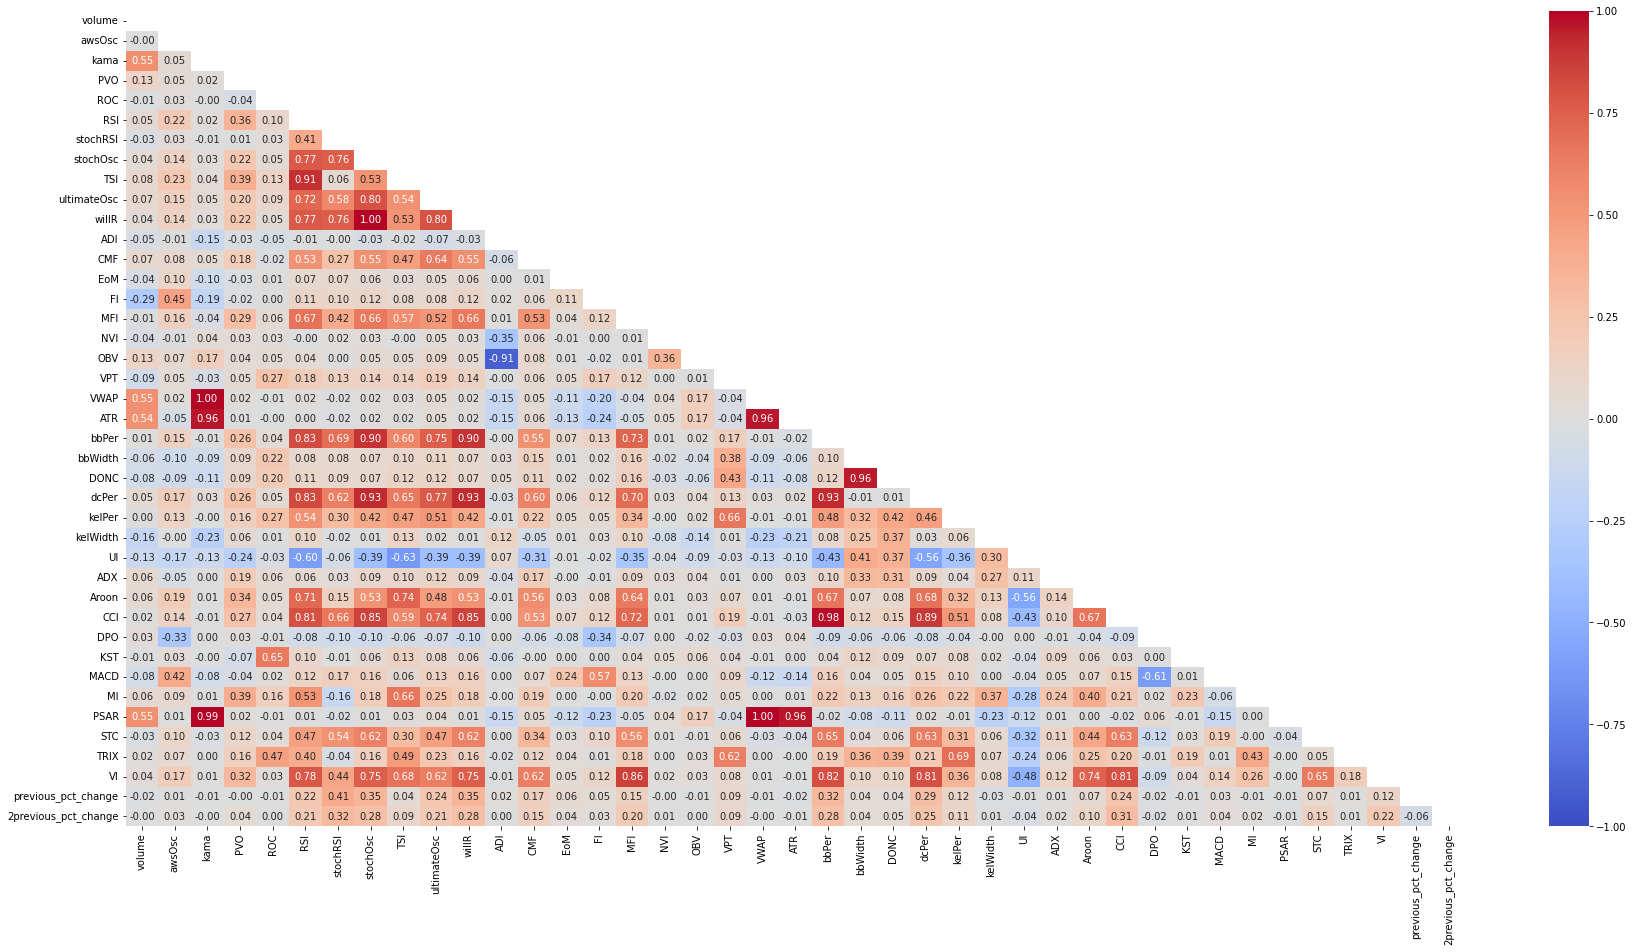

In [14]:
mask = np.zeros_like(X_train[num_features].corr())
mask[np.triu_indices_from(mask)] = True
cor_mat = sns.heatmap(X_train[num_features].corr(
), mask=mask, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

# X_train[num_features].corr()


Finding highly correlated features

In [16]:
def find_correlated_features(df, threshold):
    # Get correlation matrix
    corr_matrix = df.corr().abs()
    # Take half of the matrix to prevent doubling results
    corr_matrix = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Restructure correlation matrix to dataframe
    df = corr_matrix.stack().reset_index()
    df.columns = ['feature1', 'feature2', 'corr_coef']
    # Apply filter and sort coefficients
    df = df[df.corr_coef >= threshold].sort_values(
        'corr_coef', ascending=False)
    return df


find_correlated_features(X_train, .87)


,feature1,feature2,corr_coef
261,stochOsc,willR,1.000000
95,kama,VWAP,0.997914
604,VWAP,PSAR,0.996179
111,kama,PSAR,0.994286
638,bbPer,CCI,0.978832
589,VWAP,ATR,0.962227
96,kama,ATR,0.961589
624,ATR,PSAR,0.961101
649,bbWidth,DONC,0.956930
368,willR,dcPer,0.926383


Dropping highly correlated features

In [17]:
correlated_features = set()
correlation_matrix = X_train.corr()

for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.87:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print(correlated_features)
X_train.drop(labels=correlated_features, axis=1, inplace=True)
X_test.drop(labels=correlated_features, axis=1, inplace=True)
X.drop(labels=correlated_features, axis=1, inplace=True)


{'CCI', 'VWAP', 'DONC', 'TSI', 'willR', 'PSAR', 'OBV', 'bbPer', 'dcPer', 'ATR'}


Shortlist of ML algorithms to be tested:

- Logistic Regression
- SVM
- Random Forest

Evaluation metrics

- Precision/Specificity: how many selected instances are relevant.
- Recall/Sensitivity: how many relevant instances are selected.
- F1 score: harmonic mean of precision and recall.
- AUC: relation between true-positive rate and false positive rate.

In [18]:
kfold_validation(LogisticRegression(random_state=0), X,
                 y, X_train, y_train, X_test, y_test)


Accuracy: 62.912% (Std: 0.472%)


             Predicted_No_breakout  Predicted_BREAKOUT
NO breakout                   3064                1413
BREKOUT                       1902                2618


              precision    recall  f1-score   support

         0.0       0.62      0.68      0.65      4477
         1.0       0.65      0.58      0.61      4520

    accuracy                           0.63      8997
   macro avg       0.63      0.63      0.63      8997
weighted avg       0.63      0.63      0.63      8997



In [19]:
cross_validation(LogisticRegression(random_state=0), X, y, _cv=5)
#cross_validation(LogisticRegression(
#    random_state=0).fit(X, y), X, y, _cv=5)

#cross_validation(LogisticRegression(
#    random_state=0).fit(X_train, y_train), X, y, _cv=5)


{'Mean Training Accuracy': 62.89015338512118,
 'Mean Training Precision': 0.6411711131933024,
 'Mean Training Recall': 0.5854341818260665,
 'Mean Training F1 Score': 0.6120347724254902,
 'Mean Validation Accuracy': 62.745065430347715,
 'Mean Validation Precision': 0.6393561712522657,
 'Mean Validation Recall': 0.5847668813776262,
 'Mean Validation F1 Score': 0.6108407444881502}

Scores mean :  62.745065430347715


Accuracy :  63.29


             Predicted_No_breakout  Predicted_BREAKOUT
NO breakout                   3067                1410
BREKOUT                       1893                2627


              precision    recall  f1-score   support

 No breakout       0.62      0.69      0.65      4477
    Breakout       0.65      0.58      0.61      4520

    accuracy                           0.63      8997
   macro avg       0.63      0.63      0.63      8997
weighted avg       0.63      0.63      0.63      8997



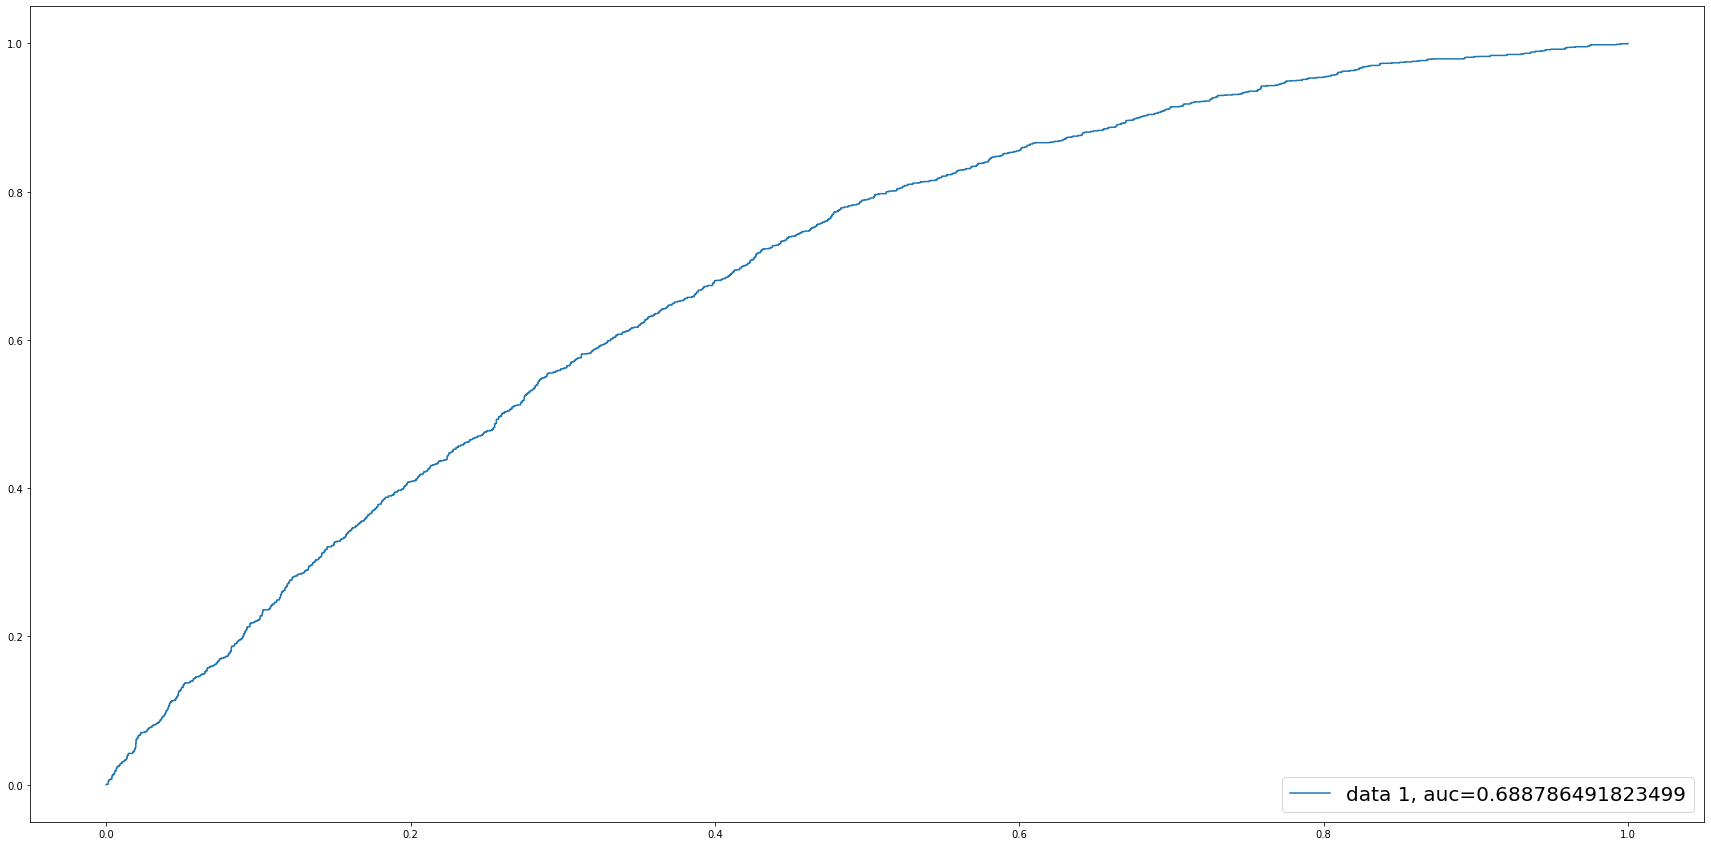

In [20]:
# Fit the model on training set
model = LogisticRegression(random_state=0).fit(X, y)
crossValScores(model, X, y, X_train, y_train, X_test, y_test)
# model = LogisticRegression(random_state=0).fit(X_train, y_train)
# crossValScores(model, X, y, X_train, y_train, X_test, y_test)


In [22]:
# Fit the model on training set
model = SVC(C=10, gamma=0.1, kernel='poly',
            random_state=0).fit(X_train, y_train)
kfold_validation(model, X, y, X_train, y_train, X_test, y_test)
# model = LogisticRegression(random_state=0).fit(X_train, y_train)
# crossValScores(model, X, y, X_train, y_train, X_test, y_test)


Accuracy: 79.829% (Std: 0.302%)


             Predicted_No_breakout  Predicted_BREAKOUT
NO breakout                   3333                1144
BREKOUT                        695                3825


              precision    recall  f1-score   support

         0.0       0.83      0.74      0.78      4477
         1.0       0.77      0.85      0.81      4520

    accuracy                           0.80      8997
   macro avg       0.80      0.80      0.79      8997
weighted avg       0.80      0.80      0.80      8997



In [23]:
# Fit the model on training set
model = RandomForestClassifier(n_estimators=200, max_depth=7, max_features='sqrt',
                               random_state=18, criterion='gini')
kfold_validation(model, X, y, X_train, y_train, X_test, y_test)
# model = LogisticRegression(random_state=0).fit(X_train, y_train)
# crossValScores(model, X, y, X_train, y_train, X_test, y_test)


Accuracy: 73.343% (Std: 0.464%)


             Predicted_No_breakout  Predicted_BREAKOUT
NO breakout                   3140                1337
BREKOUT                       1040                3480


              precision    recall  f1-score   support

         0.0       0.75      0.70      0.73      4477
         1.0       0.72      0.77      0.75      4520

    accuracy                           0.74      8997
   macro avg       0.74      0.74      0.74      8997
weighted avg       0.74      0.74      0.74      8997

